In [1]:
import os
import glob
import cv2
import pickle
import deeplabcut

import numpy as np

Loading DLC 2.2.1.1...


c:\Users\Tytell_Admin\.conda\envs\DEEPLABCUT\lib\site-packages\statsmodels\compat\pandas.py:65: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex
c:\Users\Tytell_Admin\.conda\envs\DEEPLABCUT\lib\site-packages\deeplabcut\__init__.py:81: UserWarning: 
        As PyTorch is not installed, unsupervised identity learning will not be available.
        Please run `pip install torch`, or ignore this warning.
        
  warnings.warn(


**calibration file: 20220729_checkerboard_cal01**

**trials: 20220729 ms06 trial 01-11 (all trials)**

# Set up the 3D DeepLabCut project

Change the base path for each different 3D project

In [2]:
base_path = r'D:\UpAndDown\UpAndDown-Ming-2023-03-27-3d'

In [3]:
config_path_3d = os.path.join(base_path, 'config.yaml')

if os.path.exists(config_path_3d):
    print('Found existing 3d project')
else:
    print('Create new 3d project!')
    deeplabcut.create_new_project_3d('UpAndDown','Ming', 2)

Found existing 3d project


Make sure you edit the 3D config.yaml file. The cameras should be named 'rear' and 'lateral', and the config file paths for the 2D tracking should be updated correctly. Also update the skeleton to match the 2D tracking.

# Do the calibration

See https://github.com/DeepLabCut/DeepLabCut/blob/master/docs/Overviewof3D.md for an overview

Most of the code below is modified from the DLC repository here: https://github.com/DeepLabCut/DeepLabCut/blob/master/deeplabcut/pose_estimation_3d/camera_calibration.py

Number of internal corners on our checkboard. (e.g., 8x8 squares has 7x7 internal corners)

In [4]:
cbrow = 9
cbcol = 6

In [5]:
cam_names = ['rear', 'lateral']

In [6]:
framedir = os.path.join(base_path, 'calibration_images')
print(framedir)
cornerdir = os.path.join(base_path, 'corners')
print(cornerdir)

D:\UpAndDown\UpAndDown-Ming-2023-03-27-3d\calibration_images
D:\UpAndDown\UpAndDown-Ming-2023-03-27-3d\corners


In [7]:
filenames = []
for cam1 in cam_names:
    fn1 = glob.glob(os.path.join(framedir, cam1 + '*.jpg'))
    fn1.sort()
    filenames.append(fn1)

filenames = np.array(filenames)

print(filenames[:,:3])

[['D:\\UpAndDown\\UpAndDown-Ming-2023-03-27-3d\\calibration_images\\rear-001.jpg'
  'D:\\UpAndDown\\UpAndDown-Ming-2023-03-27-3d\\calibration_images\\rear-002.jpg'
  'D:\\UpAndDown\\UpAndDown-Ming-2023-03-27-3d\\calibration_images\\rear-003.jpg']
 ['D:\\UpAndDown\\UpAndDown-Ming-2023-03-27-3d\\calibration_images\\lateral-001.jpg'
  'D:\\UpAndDown\\UpAndDown-Ming-2023-03-27-3d\\calibration_images\\lateral-002.jpg'
  'D:\\UpAndDown\\UpAndDown-Ming-2023-03-27-3d\\calibration_images\\lateral-003.jpg']]


In [8]:
def dir_name(path):
    file_list = os.listdir(path)
    file_name_list = []
    for i in range(len(file_list)):
        file_name = path + '/' + file_list[i]
        file_name_list.append(file_name)
    return file_name_list

def files_name(path):
    filesname_list = []
    for i in range(len(path)):
        (filepath, tempfilename) = os.path.split(path[i])
        (filesname, extension) = os.path.splitext(tempfilename)
        filesname_list.append(filesname)
    print(filesname_list)
    return filesname_list


In [9]:
files_path = dir_name(framedir)

In [10]:
rotategrid = {}
keys = files_name(files_path)
values = [{'fliplr': True, 'rotate': 0},
          {'fliplr': False, 'rotate': 0}]

for i in keys:
        if i.startswith('lateral'):
                rotategrid[i] = values[0]
                
        else:
                rotategrid[i] = values[1]

print(rotategrid)

['lateral-001', 'lateral-002', 'lateral-003', 'lateral-004', 'lateral-005', 'lateral-006', 'lateral-007', 'lateral-008', 'lateral-009', 'lateral-010', 'lateral-011', 'lateral-012', 'lateral-013', 'lateral-014', 'lateral-015', 'lateral-016', 'lateral-017', 'lateral-018', 'lateral-019', 'lateral-020', 'lateral-021', 'lateral-022', 'lateral-023', 'lateral-024', 'lateral-025', 'lateral-026', 'lateral-027', 'lateral-028', 'lateral-029', 'lateral-030', 'lateral-031', 'lateral-032', 'lateral-033', 'lateral-034', 'lateral-035', 'lateral-036', 'lateral-037', 'lateral-038', 'lateral-039', 'lateral-040', 'lateral-041', 'lateral-042', 'lateral-043', 'lateral-044', 'lateral-045', 'lateral-046', 'lateral-047', 'lateral-048', 'lateral-049', 'lateral-050', 'lateral-051', 'lateral-052', 'lateral-053', 'lateral-054', 'lateral-055', 'lateral-056', 'lateral-057', 'lateral-058', 'lateral-059', 'lateral-060', 'lateral-061', 'lateral-062', 'lateral-063', 'lateral-064', 'lateral-065', 'lateral-066', 'lateral-

In [11]:
# Termination criteria
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

In [12]:
# Prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((cbrow * cbcol, 3), np.float32)
objp[:, :2] = np.mgrid[0:cbcol, 0:cbrow].T.reshape(-1, 2)

In [13]:
img_shape = {}
objpoints = {}  # 3d point in real world space
imgpoints = {}  # 2d points in image plane.
dist_pickle = {}
stereo_params = {}
for cam in cam_names:
    objpoints.setdefault(cam, [])
    imgpoints.setdefault(cam, [])
    dist_pickle.setdefault(cam, [])

for cam, camfiles1 in zip(cam_names, filenames):
    for fn1 in camfiles1:
        img = cv2.imread(fn1)  # read in an image
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # convert the color of an image 
 
        pn, fn = os.path.split(fn1)
        fn, ext = os.path.splitext(fn)

        print('{}'.format(fn))
        ret, corners = cv2.findChessboardCorners(gray, (cbcol,cbrow), cv2.CALIB_CB_ADAPTIVE_THRESH + \
            cv2.CALIB_CB_FAST_CHECK + cv2.CALIB_CB_NORMALIZE_IMAGE)

        if ret:
            print('Found checkboard corners!')

            corners = cv2.cornerSubPix(gray, corners, (11, 11), (-1, -1), criteria)

            if fn in rotategrid:
                # corners = corners.reshape((cbcol,cbrow, -1))  # divide into cbcol matrices, each has cbrow rows and 1 col.
                corners = corners.reshape((cbrow,cbcol, -1))

                if 'fliplr' in rotategrid[fn] and \
                    rotategrid[fn]['fliplr']:
                    corners = np.flip(corners, axis=1)
                    # corners = np.fliplr(corners)
                
                if 'rotate' in rotategrid[fn]:
                    r = rotategrid[fn]['rotate']

                    if r == 90:
                        k = 1
                    elif r == -90:
                        k = -1
                    elif r == 180:
                        k = 2
                    else:
                        k = 0

                    corners = np.rot90(corners, k, axes=(0, 1))

                corners = corners.reshape(cbrow*cbcol, 1, -1)
            
            img_shape[cam] = gray.shape[::-1]
            objpoints[cam].append(objp)
            imgpoints[cam].append(corners)            
        else:
            print('Not found')

        img = cv2.drawChessboardCorners(img, (cbcol,cbrow), corners, ret)

        cv2.imwrite(os.path.join(cornerdir, fn + '_corner.jpg'), img)


rear-001
Found checkboard corners!
rear-002
Found checkboard corners!
rear-003
Found checkboard corners!
rear-004
Found checkboard corners!
rear-005
Found checkboard corners!
rear-006
Found checkboard corners!
rear-007
Found checkboard corners!
rear-008
Found checkboard corners!
rear-009
Found checkboard corners!
rear-010
Found checkboard corners!
rear-011
Found checkboard corners!
rear-012
Found checkboard corners!
rear-013
Found checkboard corners!
rear-014
Found checkboard corners!
rear-015
Found checkboard corners!
rear-016
Found checkboard corners!
rear-017
Found checkboard corners!
rear-018
Found checkboard corners!
rear-019
Found checkboard corners!
rear-020
Found checkboard corners!
rear-021
Found checkboard corners!
rear-022
Found checkboard corners!
rear-023
Found checkboard corners!
rear-024
Found checkboard corners!
rear-025
Found checkboard corners!
rear-026
Found checkboard corners!
rear-027
Found checkboard corners!
rear-028
Found checkboard corners!
rear-029
Found check

In [14]:
path_camera_matrix = os.path.join(base_path,'camera_matrix')

In [15]:
alpha = 0.8

In [16]:
for cam in cam_names:
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(
        objpoints[cam], imgpoints[cam], img_shape[cam], None, None
    )

    # Save the camera calibration result for later use (we won't use rvecs / tvecs)
    dist_pickle[cam] = {
        "mtx": mtx,
        "dist": dist,
        "objpoints": objpoints[cam],
        "imgpoints": imgpoints[cam],
    }
    pickle.dump(
        dist_pickle,
        open(
            os.path.join(path_camera_matrix, cam + "_intrinsic_params.pickle"),
            "wb",
        ),
    )
    print(
        "Saving intrinsic camera calibration matrices for %s as a pickle file in %s"
        % (cam, os.path.join(path_camera_matrix))
    )

    # Compute mean re-projection errors for individual cameras
    mean_error = 0
    for i in range(len(objpoints[cam])):
        imgpoints_proj, _ = cv2.projectPoints(
            objpoints[cam][i], rvecs[i], tvecs[i], mtx, dist
        )
        error = cv2.norm(imgpoints[cam][i], imgpoints_proj, cv2.NORM_L2) / len(
            imgpoints_proj
        )
        mean_error += error
    print(
        "Mean re-projection error for %s images: %.3f pixels "
        % (cam, mean_error / len(objpoints[cam]))
    )


Saving intrinsic camera calibration matrices for rear as a pickle file in D:\UpAndDown\UpAndDown-Ming-2023-03-27-3d\camera_matrix
Mean re-projection error for rear images: 0.092 pixels 
Saving intrinsic camera calibration matrices for lateral as a pickle file in D:\UpAndDown\UpAndDown-Ming-2023-03-27-3d\camera_matrix
Mean re-projection error for lateral images: 0.031 pixels 


In [17]:
# print(img.shape[:2])
h, w = img.shape[:2]
print(h, w)

1104 2560


In [18]:
# Compute stereo calibration for each pair of cameras
camera_pair = [[cam_names[0], cam_names[1]]]
for pair in camera_pair:
    print("Computing stereo calibration for " % pair)
    (
        retval,
        cameraMatrix1,
        distCoeffs1,
        cameraMatrix2,
        distCoeffs2,
        R,
        T,
        E,
        F,
    ) = cv2.stereoCalibrate(
        objpoints[pair[0]],
        imgpoints[pair[0]],
        imgpoints[pair[1]],
        dist_pickle[pair[0]]["mtx"],
        dist_pickle[pair[0]]["dist"],
        dist_pickle[pair[1]]["mtx"],
        dist_pickle[pair[1]]["dist"],
        (h, w),
        flags=cv2.CALIB_FIX_INTRINSIC,
    )

    # Stereo Rectification
    rectify_scale = alpha  # Free scaling parameter check this https://docs.opencv.org/2.4/modules/calib3d/doc/camera_calibration_and_3d_reconstruction.html#fisheye-stereorectify
    R1, R2, P1, P2, Q, roi1, roi2 = cv2.stereoRectify(
        cameraMatrix1,
        distCoeffs1,
        cameraMatrix2,
        distCoeffs2,
        (h, w),
        R,
        T,
        alpha=rectify_scale,
    )

    stereo_params[pair[0] + "-" + pair[1]] = {
        "cameraMatrix1": cameraMatrix1,
        "cameraMatrix2": cameraMatrix2,
        "distCoeffs1": distCoeffs1,
        "distCoeffs2": distCoeffs2,
        "R": R,
        "T": T,
        "E": E,
        "F": F,
        "R1": R1,
        "R2": R2,
        "P1": P1,
        "P2": P2,
        "roi1": roi1,
        "roi2": roi2,
        "Q": Q,
        "image_shape": [img_shape[pair[0]], img_shape[pair[1]]],
    }

print(
    "Saving the stereo parameters for every pair of cameras as a pickle file in %s"
    % str(os.path.join(path_camera_matrix))
)

deeplabcut.auxiliaryfunctions.write_pickle(
    os.path.join(path_camera_matrix, "stereo_params.pickle"), stereo_params
)
print(
    "Camera calibration done! Use the function ``check_undistortion`` to check the check the calibration"
)

Computing stereo calibration for 
Saving the stereo parameters for every pair of cameras as a pickle file in D:\UpAndDown\UpAndDown-Ming-2023-03-27-3d\camera_matrix
Camera calibration done! Use the function ``check_undistortion`` to check the check the calibration


In [19]:
cameraMatrix2

array([[6.13786703e+03, 0.00000000e+00, 1.26701323e+03],
       [0.00000000e+00, 5.31534090e+03, 5.58879027e+02],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])

## Check undistortion

This doesn't work, but the triangulation does. Just skip to the triangulation section

In [ ]:
deeplabcut.check_undistortion(config_path_3d, cbrow=cbrow, cbcol=cbcol)

In [ ]:
camera_pair = [[cam_names[0], cam_names[1]]]

In [ ]:
path_undistort = os.path.join(base_path, 'undistortion')

In [ ]:
pairname = camera_pair[0][0] + "-" + camera_pair[0][1]
map2_x, map2_y = cv2.initUndistortRectifyMap(
    stereo_params[pairname]["cameraMatrix2"],
    stereo_params[pairname]["distCoeffs2"],
    stereo_params[pairname]["R2"],
    stereo_params[pairname]["P2"],
    (stereo_params[pairname]["image_shape"][1]),
    cv2.CV_16SC2,
)
 

In [ ]:
map2_x

In [ ]:
for pair in camera_pair:
        map1_x, map1_y = cv2.initUndistortRectifyMap(
            stereo_params[pair[0] + "-" + pair[1]]["cameraMatrix1"],
            stereo_params[pair[0] + "-" + pair[1]]["distCoeffs1"],
            stereo_params[pair[0] + "-" + pair[1]]["R1"],
            stereo_params[pair[0] + "-" + pair[1]]["P1"],
            (stereo_params[pair[0] + "-" + pair[1]]["image_shape"][0]),
            cv2.CV_16SC2,
        )
        map2_x, map2_y = cv2.initUndistortRectifyMap(
            stereo_params[pair[0] + "-" + pair[1]]["cameraMatrix2"],
            stereo_params[pair[0] + "-" + pair[1]]["distCoeffs2"],
            stereo_params[pair[0] + "-" + pair[1]]["R2"],
            stereo_params[pair[0] + "-" + pair[1]]["P2"],
            (stereo_params[pair[0] + "-" + pair[1]]["image_shape"][1]),
            cv2.CV_16SC2,
        )
        cam1_undistort = []
        cam2_undistort = []

        for camnum, (cam, camfiles1, rot1) in enumerate(zip(cam_names, filenames, rotategrid)):
            for fname in camfiles1:
                _, filename = os.path.split(fname)
                img1 = cv2.imread(fname)
                gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
                h, w = img1.shape[:2]
                _, corners1 = cv2.findChessboardCorners(gray1, (cbcol, cbrow),  cv2.CALIB_CB_ADAPTIVE_THRESH + \
            cv2.CALIB_CB_FAST_CHECK + cv2.CALIB_CB_NORMALIZE_IMAGE)
                
                if rot1:
                    corners1 = corners1.reshape((cbrow,cbcol, -1))
                    corners1 = corners1.transpose((1, 0, 2))
                    corners1 = corners1.reshape((cbrow*cbcol, 1, -1))

                corners_origin1 = cv2.cornerSubPix(
                    gray1, corners1, (11, 11), (-1, -1), criteria
                )
                

                # Remapping dataFrame_camera1_undistort
                im_remapped1 = cv2.remap(gray1, map1_x, map1_y, cv2.INTER_LANCZOS4)
                imgpoints_proj_undistort = cv2.undistortPoints(
                    src=corners_origin1,
                    cameraMatrix=stereo_params[pair[0] + "-" + pair[1]][
                        "cameraMatrix{}".format(camnum+1)
                    ],
                    distCoeffs=stereo_params[pair[0] + "-" + pair[1]]["distCoeffs{}".format(camnum+1)],
                    P=stereo_params[pair[0] + "-" + pair[1]]["P{}".format(camnum+1)],
                    R=stereo_params[pair[0] + "-" + pair[1]]["R{}".format(camnum+1)],
                )
                cam1_undistort.append(imgpoints_proj_undistort)
                cv2.imwrite(
                    os.path.join(str(path_undistort), filename + "_undistort.jpg"),
                    im_remapped1,
                )
                imgpoints_proj_undistort = []

In [ ]:

        cam1_undistort = np.array(cam1_undistort)
        cam2_undistort = np.array(cam2_undistort)
        print("All images are undistorted and stored in %s" % str(path_undistort))
        print(
            "Use the function ``triangulate`` to undistort the dataframes and compute the triangulation"
        )

        if plot == True:
            f1, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
            f1.suptitle(
                str("Original Image: Views from " + pair[0] + " and " + pair[1]),
                fontsize=25,
            )

            # Display images in RGB
            ax1.imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
            ax2.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))

            norm = mcolors.Normalize(vmin=0.0, vmax=cam1_undistort.shape[1])
            plt.savefig(os.path.join(str(path_undistort), "Original_Image.png"))

            # Plot the undistorted corner points
            f2, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
            f2.suptitle(
                "Undistorted corner points on camera-1 and camera-2", fontsize=25
            )
            ax1.imshow(cv2.cvtColor(im_remapped1, cv2.COLOR_BGR2RGB))
            ax2.imshow(cv2.cvtColor(im_remapped2, cv2.COLOR_BGR2RGB))
            for i in range(0, cam1_undistort.shape[1]):
                ax1.scatter(
                    [cam1_undistort[-1][i, 0, 0]],
                    [cam1_undistort[-1][i, 0, 1]],
                    marker=markerType,
                    s=markerSize,
                    color=markerColor,
                    alpha=alphaValue,
                )
                ax2.scatter(
                    [cam2_undistort[-1][i, 0, 0]],
                    [cam2_undistort[-1][i, 0, 1]],
                    marker=markerType,
                    s=markerSize,
                    color=markerColor,
                    alpha=alphaValue,
                )
            plt.savefig(os.path.join(str(path_undistort), "undistorted_points.png"))

            # Triangulate
            triangulate = auxiliaryfunctions_3d.compute_triangulation_calibration_images(
                stereo_params[pair[0] + "-" + pair[1]],
                cam1_undistort,
                cam2_undistort,
                path_undistort,
                cfg_3d,
                plot=True,
            )
            auxiliaryfunctions.write_pickle("triangulate.pickle", triangulate)

# Triangulate

In [20]:
deeplabcut.triangulate(config_path_3d, r'D:\UpAndDown\UpAndDown-Ming-2023-03-27-3d\videos',
                    videotype='.mp4', save_as_csv=True)

List of pairs: [['D:\\UpAndDown\\UpAndDown-Ming-2023-03-27-3d\\videos\\20220729_ms06_trial01_rear.mp4', 'D:\\UpAndDown\\UpAndDown-Ming-2023-03-27-3d\\videos\\20220729_ms06_trial01_lateral.mp4'], ['D:\\UpAndDown\\UpAndDown-Ming-2023-03-27-3d\\videos\\20220729_ms06_trial02_rear.mp4', 'D:\\UpAndDown\\UpAndDown-Ming-2023-03-27-3d\\videos\\20220729_ms06_trial02_lateral.mp4'], ['D:\\UpAndDown\\UpAndDown-Ming-2023-03-27-3d\\videos\\20220729_ms06_trial03_rear.mp4', 'D:\\UpAndDown\\UpAndDown-Ming-2023-03-27-3d\\videos\\20220729_ms06_trial03_lateral.mp4'], ['D:\\UpAndDown\\UpAndDown-Ming-2023-03-27-3d\\videos\\20220729_ms06_trial04_rear.mp4', 'D:\\UpAndDown\\UpAndDown-Ming-2023-03-27-3d\\videos\\20220729_ms06_trial04_lateral.mp4'], ['D:\\UpAndDown\\UpAndDown-Ming-2023-03-27-3d\\videos\\20220729_ms06_trial05_rear.mp4', 'D:\\UpAndDown\\UpAndDown-Ming-2023-03-27-3d\\videos\\20220729_ms06_trial05_lateral.mp4'], ['D:\\UpAndDown\\UpAndDown-Ming-2023-03-27-3d\\videos\\20220729_ms06_trial06_rear.mp4', '

c:\Users\Tytell_Admin\.conda\envs\DEEPLABCUT\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Starting to analyze %  D:\UpAndDown\UpAndDown-Ming-2023-03-27-3d\videos\20220729_ms06_trial01_rear.mp4
The videos are analyzed. Now your research can truly start! 
 You can create labeled videos with 'create_labeled_video'
If the tracking is not satisfactory for some videos, consider expanding the training set. You can use the function 'extract_outlier_frames' to extract a few representative outlier frames.
D:\UpAndDown\UpAndDown-Ming-2023-03-27-3d\videos 20220729_ms06_trial01_rear DLC_resnet50_UpAndDownRear4Feb10shuffle1_500000
Filtering with median model D:\UpAndDown\UpAndDown-Ming-2023-03-27-3d\videos\20220729_ms06_trial01_rear.mp4
Data from 20220729_ms06_trial01_rear were already filtered. Skipping...
Analyzing video D:\UpAndDown\UpAndDown-Ming-2023-03-27-3d\videos\20220729_ms06_trial01_lateral.mp4 using config_file_lateral
Using snapshot-500000 for model D:\UpAndDown\UpAndDownLateral5-MingGong-2023-02-08\dlc-models\iteration-0\Lateral5Feb8-trainset95shuffle1


c:\Users\Tytell_Admin\.conda\envs\DEEPLABCUT\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Starting to analyze %  D:\UpAndDown\UpAndDown-Ming-2023-03-27-3d\videos\20220729_ms06_trial01_lateral.mp4
The videos are analyzed. Now your research can truly start! 
 You can create labeled videos with 'create_labeled_video'
If the tracking is not satisfactory for some videos, consider expanding the training set. You can use the function 'extract_outlier_frames' to extract a few representative outlier frames.
D:\UpAndDown\UpAndDown-Ming-2023-03-27-3d\videos 20220729_ms06_trial01_lateral DLC_resnet50_Lateral5Feb8shuffle1_500000
Filtering with median model D:\UpAndDown\UpAndDown-Ming-2023-03-27-3d\videos\20220729_ms06_trial01_lateral.mp4
Saving filtered csv poses!
Undistorting...
Computing the triangulation...
Triangulated data for video ['D:\\UpAndDown\\UpAndDown-Ming-2023-03-27-3d\\videos\\20220729_ms06_trial01_rear.mp4', 'D:\\UpAndDown\\UpAndDown-Ming-2023-03-27-3d\\videos\\20220729_ms06_trial01_lateral.mp4']
Results are saved under:  D:\UpAndDown\UpAndDown-Ming-2023-03-27-3d\videos


c:\Users\Tytell_Admin\.conda\envs\DEEPLABCUT\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Starting to analyze %  D:\UpAndDown\UpAndDown-Ming-2023-03-27-3d\videos\20220729_ms06_trial02_rear.mp4
The videos are analyzed. Now your research can truly start! 
 You can create labeled videos with 'create_labeled_video'
If the tracking is not satisfactory for some videos, consider expanding the training set. You can use the function 'extract_outlier_frames' to extract a few representative outlier frames.
D:\UpAndDown\UpAndDown-Ming-2023-03-27-3d\videos 20220729_ms06_trial02_rear DLC_resnet50_UpAndDownRear4Feb10shuffle1_500000
Filtering with median model D:\UpAndDown\UpAndDown-Ming-2023-03-27-3d\videos\20220729_ms06_trial02_rear.mp4
Data from 20220729_ms06_trial02_rear were already filtered. Skipping...
Analyzing video D:\UpAndDown\UpAndDown-Ming-2023-03-27-3d\videos\20220729_ms06_trial02_lateral.mp4 using config_file_lateral
Using snapshot-500000 for model D:\UpAndDown\UpAndDownLateral5-MingGong-2023-02-08\dlc-models\iteration-0\Lateral5Feb8-trainset95shuffle1


c:\Users\Tytell_Admin\.conda\envs\DEEPLABCUT\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Starting to analyze %  D:\UpAndDown\UpAndDown-Ming-2023-03-27-3d\videos\20220729_ms06_trial02_lateral.mp4
The videos are analyzed. Now your research can truly start! 
 You can create labeled videos with 'create_labeled_video'
If the tracking is not satisfactory for some videos, consider expanding the training set. You can use the function 'extract_outlier_frames' to extract a few representative outlier frames.
D:\UpAndDown\UpAndDown-Ming-2023-03-27-3d\videos 20220729_ms06_trial02_lateral DLC_resnet50_Lateral5Feb8shuffle1_500000
Filtering with median model D:\UpAndDown\UpAndDown-Ming-2023-03-27-3d\videos\20220729_ms06_trial02_lateral.mp4
Saving filtered csv poses!
Undistorting...
Computing the triangulation...
Triangulated data for video ['D:\\UpAndDown\\UpAndDown-Ming-2023-03-27-3d\\videos\\20220729_ms06_trial01_rear.mp4', 'D:\\UpAndDown\\UpAndDown-Ming-2023-03-27-3d\\videos\\20220729_ms06_trial01_lateral.mp4']
Results are saved under:  D:\UpAndDown\UpAndDown-Ming-2023-03-27-3d\videos


c:\Users\Tytell_Admin\.conda\envs\DEEPLABCUT\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Starting to analyze %  D:\UpAndDown\UpAndDown-Ming-2023-03-27-3d\videos\20220729_ms06_trial03_rear.mp4
The videos are analyzed. Now your research can truly start! 
 You can create labeled videos with 'create_labeled_video'
If the tracking is not satisfactory for some videos, consider expanding the training set. You can use the function 'extract_outlier_frames' to extract a few representative outlier frames.
D:\UpAndDown\UpAndDown-Ming-2023-03-27-3d\videos 20220729_ms06_trial03_rear DLC_resnet50_UpAndDownRear4Feb10shuffle1_500000
Filtering with median model D:\UpAndDown\UpAndDown-Ming-2023-03-27-3d\videos\20220729_ms06_trial03_rear.mp4
Data from 20220729_ms06_trial03_rear were already filtered. Skipping...
Analyzing video D:\UpAndDown\UpAndDown-Ming-2023-03-27-3d\videos\20220729_ms06_trial03_lateral.mp4 using config_file_lateral
Using snapshot-500000 for model D:\UpAndDown\UpAndDownLateral5-MingGong-2023-02-08\dlc-models\iteration-0\Lateral5Feb8-trainset95shuffle1


c:\Users\Tytell_Admin\.conda\envs\DEEPLABCUT\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Starting to analyze %  D:\UpAndDown\UpAndDown-Ming-2023-03-27-3d\videos\20220729_ms06_trial03_lateral.mp4
The videos are analyzed. Now your research can truly start! 
 You can create labeled videos with 'create_labeled_video'
If the tracking is not satisfactory for some videos, consider expanding the training set. You can use the function 'extract_outlier_frames' to extract a few representative outlier frames.
D:\UpAndDown\UpAndDown-Ming-2023-03-27-3d\videos 20220729_ms06_trial03_lateral DLC_resnet50_Lateral5Feb8shuffle1_500000
Filtering with median model D:\UpAndDown\UpAndDown-Ming-2023-03-27-3d\videos\20220729_ms06_trial03_lateral.mp4
Saving filtered csv poses!
Undistorting...
Computing the triangulation...
Triangulated data for video ['D:\\UpAndDown\\UpAndDown-Ming-2023-03-27-3d\\videos\\20220729_ms06_trial01_rear.mp4', 'D:\\UpAndDown\\UpAndDown-Ming-2023-03-27-3d\\videos\\20220729_ms06_trial01_lateral.mp4']
Results are saved under:  D:\UpAndDown\UpAndDown-Ming-2023-03-27-3d\videos


c:\Users\Tytell_Admin\.conda\envs\DEEPLABCUT\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Starting to analyze %  D:\UpAndDown\UpAndDown-Ming-2023-03-27-3d\videos\20220729_ms06_trial04_rear.mp4
The videos are analyzed. Now your research can truly start! 
 You can create labeled videos with 'create_labeled_video'
If the tracking is not satisfactory for some videos, consider expanding the training set. You can use the function 'extract_outlier_frames' to extract a few representative outlier frames.
D:\UpAndDown\UpAndDown-Ming-2023-03-27-3d\videos 20220729_ms06_trial04_rear DLC_resnet50_UpAndDownRear4Feb10shuffle1_500000
Filtering with median model D:\UpAndDown\UpAndDown-Ming-2023-03-27-3d\videos\20220729_ms06_trial04_rear.mp4
Data from 20220729_ms06_trial04_rear were already filtered. Skipping...
Analyzing video D:\UpAndDown\UpAndDown-Ming-2023-03-27-3d\videos\20220729_ms06_trial04_lateral.mp4 using config_file_lateral
Using snapshot-500000 for model D:\UpAndDown\UpAndDownLateral5-MingGong-2023-02-08\dlc-models\iteration-0\Lateral5Feb8-trainset95shuffle1


c:\Users\Tytell_Admin\.conda\envs\DEEPLABCUT\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Starting to analyze %  D:\UpAndDown\UpAndDown-Ming-2023-03-27-3d\videos\20220729_ms06_trial04_lateral.mp4
The videos are analyzed. Now your research can truly start! 
 You can create labeled videos with 'create_labeled_video'
If the tracking is not satisfactory for some videos, consider expanding the training set. You can use the function 'extract_outlier_frames' to extract a few representative outlier frames.
D:\UpAndDown\UpAndDown-Ming-2023-03-27-3d\videos 20220729_ms06_trial04_lateral DLC_resnet50_Lateral5Feb8shuffle1_500000
Filtering with median model D:\UpAndDown\UpAndDown-Ming-2023-03-27-3d\videos\20220729_ms06_trial04_lateral.mp4
Saving filtered csv poses!
Undistorting...
Computing the triangulation...
Triangulated data for video ['D:\\UpAndDown\\UpAndDown-Ming-2023-03-27-3d\\videos\\20220729_ms06_trial01_rear.mp4', 'D:\\UpAndDown\\UpAndDown-Ming-2023-03-27-3d\\videos\\20220729_ms06_trial01_lateral.mp4']
Results are saved under:  D:\UpAndDown\UpAndDown-Ming-2023-03-27-3d\videos


c:\Users\Tytell_Admin\.conda\envs\DEEPLABCUT\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Starting to analyze %  D:\UpAndDown\UpAndDown-Ming-2023-03-27-3d\videos\20220729_ms06_trial05_rear.mp4
The videos are analyzed. Now your research can truly start! 
 You can create labeled videos with 'create_labeled_video'
If the tracking is not satisfactory for some videos, consider expanding the training set. You can use the function 'extract_outlier_frames' to extract a few representative outlier frames.
D:\UpAndDown\UpAndDown-Ming-2023-03-27-3d\videos 20220729_ms06_trial05_rear DLC_resnet50_UpAndDownRear4Feb10shuffle1_500000
Filtering with median model D:\UpAndDown\UpAndDown-Ming-2023-03-27-3d\videos\20220729_ms06_trial05_rear.mp4
Data from 20220729_ms06_trial05_rear were already filtered. Skipping...
Analyzing video D:\UpAndDown\UpAndDown-Ming-2023-03-27-3d\videos\20220729_ms06_trial05_lateral.mp4 using config_file_lateral
Using snapshot-500000 for model D:\UpAndDown\UpAndDownLateral5-MingGong-2023-02-08\dlc-models\iteration-0\Lateral5Feb8-trainset95shuffle1


c:\Users\Tytell_Admin\.conda\envs\DEEPLABCUT\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Starting to analyze %  D:\UpAndDown\UpAndDown-Ming-2023-03-27-3d\videos\20220729_ms06_trial05_lateral.mp4
The videos are analyzed. Now your research can truly start! 
 You can create labeled videos with 'create_labeled_video'
If the tracking is not satisfactory for some videos, consider expanding the training set. You can use the function 'extract_outlier_frames' to extract a few representative outlier frames.
D:\UpAndDown\UpAndDown-Ming-2023-03-27-3d\videos 20220729_ms06_trial05_lateral DLC_resnet50_Lateral5Feb8shuffle1_500000
Filtering with median model D:\UpAndDown\UpAndDown-Ming-2023-03-27-3d\videos\20220729_ms06_trial05_lateral.mp4
Saving filtered csv poses!
Undistorting...
Computing the triangulation...
Triangulated data for video ['D:\\UpAndDown\\UpAndDown-Ming-2023-03-27-3d\\videos\\20220729_ms06_trial01_rear.mp4', 'D:\\UpAndDown\\UpAndDown-Ming-2023-03-27-3d\\videos\\20220729_ms06_trial01_lateral.mp4']
Results are saved under:  D:\UpAndDown\UpAndDown-Ming-2023-03-27-3d\videos


c:\Users\Tytell_Admin\.conda\envs\DEEPLABCUT\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Starting to analyze %  D:\UpAndDown\UpAndDown-Ming-2023-03-27-3d\videos\20220729_ms06_trial06_rear.mp4
The videos are analyzed. Now your research can truly start! 
 You can create labeled videos with 'create_labeled_video'
If the tracking is not satisfactory for some videos, consider expanding the training set. You can use the function 'extract_outlier_frames' to extract a few representative outlier frames.
D:\UpAndDown\UpAndDown-Ming-2023-03-27-3d\videos 20220729_ms06_trial06_rear DLC_resnet50_UpAndDownRear4Feb10shuffle1_500000
Filtering with median model D:\UpAndDown\UpAndDown-Ming-2023-03-27-3d\videos\20220729_ms06_trial06_rear.mp4
Data from 20220729_ms06_trial06_rear were already filtered. Skipping...
Analyzing video D:\UpAndDown\UpAndDown-Ming-2023-03-27-3d\videos\20220729_ms06_trial06_lateral.mp4 using config_file_lateral
Using snapshot-500000 for model D:\UpAndDown\UpAndDownLateral5-MingGong-2023-02-08\dlc-models\iteration-0\Lateral5Feb8-trainset95shuffle1


c:\Users\Tytell_Admin\.conda\envs\DEEPLABCUT\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Starting to analyze %  D:\UpAndDown\UpAndDown-Ming-2023-03-27-3d\videos\20220729_ms06_trial06_lateral.mp4
The videos are analyzed. Now your research can truly start! 
 You can create labeled videos with 'create_labeled_video'
If the tracking is not satisfactory for some videos, consider expanding the training set. You can use the function 'extract_outlier_frames' to extract a few representative outlier frames.
D:\UpAndDown\UpAndDown-Ming-2023-03-27-3d\videos 20220729_ms06_trial06_lateral DLC_resnet50_Lateral5Feb8shuffle1_500000
Filtering with median model D:\UpAndDown\UpAndDown-Ming-2023-03-27-3d\videos\20220729_ms06_trial06_lateral.mp4
Saving filtered csv poses!
Undistorting...
Computing the triangulation...
Triangulated data for video ['D:\\UpAndDown\\UpAndDown-Ming-2023-03-27-3d\\videos\\20220729_ms06_trial01_rear.mp4', 'D:\\UpAndDown\\UpAndDown-Ming-2023-03-27-3d\\videos\\20220729_ms06_trial01_lateral.mp4']
Results are saved under:  D:\UpAndDown\UpAndDown-Ming-2023-03-27-3d\videos


c:\Users\Tytell_Admin\.conda\envs\DEEPLABCUT\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Starting to analyze %  D:\UpAndDown\UpAndDown-Ming-2023-03-27-3d\videos\20220729_ms06_trial07_rear.mp4
The videos are analyzed. Now your research can truly start! 
 You can create labeled videos with 'create_labeled_video'
If the tracking is not satisfactory for some videos, consider expanding the training set. You can use the function 'extract_outlier_frames' to extract a few representative outlier frames.
D:\UpAndDown\UpAndDown-Ming-2023-03-27-3d\videos 20220729_ms06_trial07_rear DLC_resnet50_UpAndDownRear4Feb10shuffle1_500000
Filtering with median model D:\UpAndDown\UpAndDown-Ming-2023-03-27-3d\videos\20220729_ms06_trial07_rear.mp4
Data from 20220729_ms06_trial07_rear were already filtered. Skipping...
Analyzing video D:\UpAndDown\UpAndDown-Ming-2023-03-27-3d\videos\20220729_ms06_trial07_lateral.mp4 using config_file_lateral
Using snapshot-500000 for model D:\UpAndDown\UpAndDownLateral5-MingGong-2023-02-08\dlc-models\iteration-0\Lateral5Feb8-trainset95shuffle1


c:\Users\Tytell_Admin\.conda\envs\DEEPLABCUT\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Starting to analyze %  D:\UpAndDown\UpAndDown-Ming-2023-03-27-3d\videos\20220729_ms06_trial07_lateral.mp4
The videos are analyzed. Now your research can truly start! 
 You can create labeled videos with 'create_labeled_video'
If the tracking is not satisfactory for some videos, consider expanding the training set. You can use the function 'extract_outlier_frames' to extract a few representative outlier frames.
D:\UpAndDown\UpAndDown-Ming-2023-03-27-3d\videos 20220729_ms06_trial07_lateral DLC_resnet50_Lateral5Feb8shuffle1_500000
Filtering with median model D:\UpAndDown\UpAndDown-Ming-2023-03-27-3d\videos\20220729_ms06_trial07_lateral.mp4
Saving filtered csv poses!
Undistorting...
Computing the triangulation...
Triangulated data for video ['D:\\UpAndDown\\UpAndDown-Ming-2023-03-27-3d\\videos\\20220729_ms06_trial01_rear.mp4', 'D:\\UpAndDown\\UpAndDown-Ming-2023-03-27-3d\\videos\\20220729_ms06_trial01_lateral.mp4']
Results are saved under:  D:\UpAndDown\UpAndDown-Ming-2023-03-27-3d\videos


c:\Users\Tytell_Admin\.conda\envs\DEEPLABCUT\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Starting to analyze %  D:\UpAndDown\UpAndDown-Ming-2023-03-27-3d\videos\20220729_ms06_trial08_rear.mp4
The videos are analyzed. Now your research can truly start! 
 You can create labeled videos with 'create_labeled_video'
If the tracking is not satisfactory for some videos, consider expanding the training set. You can use the function 'extract_outlier_frames' to extract a few representative outlier frames.
D:\UpAndDown\UpAndDown-Ming-2023-03-27-3d\videos 20220729_ms06_trial08_rear DLC_resnet50_UpAndDownRear4Feb10shuffle1_500000
Filtering with median model D:\UpAndDown\UpAndDown-Ming-2023-03-27-3d\videos\20220729_ms06_trial08_rear.mp4
Data from 20220729_ms06_trial08_rear were already filtered. Skipping...
Analyzing video D:\UpAndDown\UpAndDown-Ming-2023-03-27-3d\videos\20220729_ms06_trial08_lateral.mp4 using config_file_lateral
Using snapshot-500000 for model D:\UpAndDown\UpAndDownLateral5-MingGong-2023-02-08\dlc-models\iteration-0\Lateral5Feb8-trainset95shuffle1


c:\Users\Tytell_Admin\.conda\envs\DEEPLABCUT\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Starting to analyze %  D:\UpAndDown\UpAndDown-Ming-2023-03-27-3d\videos\20220729_ms06_trial08_lateral.mp4
The videos are analyzed. Now your research can truly start! 
 You can create labeled videos with 'create_labeled_video'
If the tracking is not satisfactory for some videos, consider expanding the training set. You can use the function 'extract_outlier_frames' to extract a few representative outlier frames.
D:\UpAndDown\UpAndDown-Ming-2023-03-27-3d\videos 20220729_ms06_trial08_lateral DLC_resnet50_Lateral5Feb8shuffle1_500000
Filtering with median model D:\UpAndDown\UpAndDown-Ming-2023-03-27-3d\videos\20220729_ms06_trial08_lateral.mp4
Saving filtered csv poses!
Undistorting...
Computing the triangulation...
Triangulated data for video ['D:\\UpAndDown\\UpAndDown-Ming-2023-03-27-3d\\videos\\20220729_ms06_trial01_rear.mp4', 'D:\\UpAndDown\\UpAndDown-Ming-2023-03-27-3d\\videos\\20220729_ms06_trial01_lateral.mp4']
Results are saved under:  D:\UpAndDown\UpAndDown-Ming-2023-03-27-3d\videos


c:\Users\Tytell_Admin\.conda\envs\DEEPLABCUT\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Starting to analyze %  D:\UpAndDown\UpAndDown-Ming-2023-03-27-3d\videos\20220729_ms06_trial09_rear.mp4
The videos are analyzed. Now your research can truly start! 
 You can create labeled videos with 'create_labeled_video'
If the tracking is not satisfactory for some videos, consider expanding the training set. You can use the function 'extract_outlier_frames' to extract a few representative outlier frames.
D:\UpAndDown\UpAndDown-Ming-2023-03-27-3d\videos 20220729_ms06_trial09_rear DLC_resnet50_UpAndDownRear4Feb10shuffle1_500000
Filtering with median model D:\UpAndDown\UpAndDown-Ming-2023-03-27-3d\videos\20220729_ms06_trial09_rear.mp4
Data from 20220729_ms06_trial09_rear were already filtered. Skipping...
Analyzing video D:\UpAndDown\UpAndDown-Ming-2023-03-27-3d\videos\20220729_ms06_trial09_lateral.mp4 using config_file_lateral
Using snapshot-500000 for model D:\UpAndDown\UpAndDownLateral5-MingGong-2023-02-08\dlc-models\iteration-0\Lateral5Feb8-trainset95shuffle1


c:\Users\Tytell_Admin\.conda\envs\DEEPLABCUT\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Starting to analyze %  D:\UpAndDown\UpAndDown-Ming-2023-03-27-3d\videos\20220729_ms06_trial09_lateral.mp4
The videos are analyzed. Now your research can truly start! 
 You can create labeled videos with 'create_labeled_video'
If the tracking is not satisfactory for some videos, consider expanding the training set. You can use the function 'extract_outlier_frames' to extract a few representative outlier frames.
D:\UpAndDown\UpAndDown-Ming-2023-03-27-3d\videos 20220729_ms06_trial09_lateral DLC_resnet50_Lateral5Feb8shuffle1_500000
Filtering with median model D:\UpAndDown\UpAndDown-Ming-2023-03-27-3d\videos\20220729_ms06_trial09_lateral.mp4
Saving filtered csv poses!
Undistorting...
Computing the triangulation...
Triangulated data for video ['D:\\UpAndDown\\UpAndDown-Ming-2023-03-27-3d\\videos\\20220729_ms06_trial01_rear.mp4', 'D:\\UpAndDown\\UpAndDown-Ming-2023-03-27-3d\\videos\\20220729_ms06_trial01_lateral.mp4']
Results are saved under:  D:\UpAndDown\UpAndDown-Ming-2023-03-27-3d\videos


c:\Users\Tytell_Admin\.conda\envs\DEEPLABCUT\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Starting to analyze %  D:\UpAndDown\UpAndDown-Ming-2023-03-27-3d\videos\20220729_ms06_trial10_rear.mp4
The videos are analyzed. Now your research can truly start! 
 You can create labeled videos with 'create_labeled_video'
If the tracking is not satisfactory for some videos, consider expanding the training set. You can use the function 'extract_outlier_frames' to extract a few representative outlier frames.
D:\UpAndDown\UpAndDown-Ming-2023-03-27-3d\videos 20220729_ms06_trial10_rear DLC_resnet50_UpAndDownRear4Feb10shuffle1_500000
Filtering with median model D:\UpAndDown\UpAndDown-Ming-2023-03-27-3d\videos\20220729_ms06_trial10_rear.mp4
Data from 20220729_ms06_trial10_rear were already filtered. Skipping...
Analyzing video D:\UpAndDown\UpAndDown-Ming-2023-03-27-3d\videos\20220729_ms06_trial10_lateral.mp4 using config_file_lateral
Using snapshot-500000 for model D:\UpAndDown\UpAndDownLateral5-MingGong-2023-02-08\dlc-models\iteration-0\Lateral5Feb8-trainset95shuffle1


c:\Users\Tytell_Admin\.conda\envs\DEEPLABCUT\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Starting to analyze %  D:\UpAndDown\UpAndDown-Ming-2023-03-27-3d\videos\20220729_ms06_trial10_lateral.mp4
The videos are analyzed. Now your research can truly start! 
 You can create labeled videos with 'create_labeled_video'
If the tracking is not satisfactory for some videos, consider expanding the training set. You can use the function 'extract_outlier_frames' to extract a few representative outlier frames.
D:\UpAndDown\UpAndDown-Ming-2023-03-27-3d\videos 20220729_ms06_trial10_lateral DLC_resnet50_Lateral5Feb8shuffle1_500000
Filtering with median model D:\UpAndDown\UpAndDown-Ming-2023-03-27-3d\videos\20220729_ms06_trial10_lateral.mp4
Saving filtered csv poses!
Undistorting...
Computing the triangulation...
Triangulated data for video ['D:\\UpAndDown\\UpAndDown-Ming-2023-03-27-3d\\videos\\20220729_ms06_trial01_rear.mp4', 'D:\\UpAndDown\\UpAndDown-Ming-2023-03-27-3d\\videos\\20220729_ms06_trial01_lateral.mp4']
Results are saved under:  D:\UpAndDown\UpAndDown-Ming-2023-03-27-3d\videos


c:\Users\Tytell_Admin\.conda\envs\DEEPLABCUT\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Starting to analyze %  D:\UpAndDown\UpAndDown-Ming-2023-03-27-3d\videos\20220729_ms06_trial11_rear.mp4
The videos are analyzed. Now your research can truly start! 
 You can create labeled videos with 'create_labeled_video'
If the tracking is not satisfactory for some videos, consider expanding the training set. You can use the function 'extract_outlier_frames' to extract a few representative outlier frames.
D:\UpAndDown\UpAndDown-Ming-2023-03-27-3d\videos 20220729_ms06_trial11_rear DLC_resnet50_UpAndDownRear4Feb10shuffle1_500000
Filtering with median model D:\UpAndDown\UpAndDown-Ming-2023-03-27-3d\videos\20220729_ms06_trial11_rear.mp4
Data from 20220729_ms06_trial11_rear were already filtered. Skipping...
Analyzing video D:\UpAndDown\UpAndDown-Ming-2023-03-27-3d\videos\20220729_ms06_trial11_lateral.mp4 using config_file_lateral
Using snapshot-500000 for model D:\UpAndDown\UpAndDownLateral5-MingGong-2023-02-08\dlc-models\iteration-0\Lateral5Feb8-trainset95shuffle1


c:\Users\Tytell_Admin\.conda\envs\DEEPLABCUT\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Starting to analyze %  D:\UpAndDown\UpAndDown-Ming-2023-03-27-3d\videos\20220729_ms06_trial11_lateral.mp4
The videos are analyzed. Now your research can truly start! 
 You can create labeled videos with 'create_labeled_video'
If the tracking is not satisfactory for some videos, consider expanding the training set. You can use the function 'extract_outlier_frames' to extract a few representative outlier frames.
D:\UpAndDown\UpAndDown-Ming-2023-03-27-3d\videos 20220729_ms06_trial11_lateral DLC_resnet50_Lateral5Feb8shuffle1_500000
Filtering with median model D:\UpAndDown\UpAndDown-Ming-2023-03-27-3d\videos\20220729_ms06_trial11_lateral.mp4
Saving filtered csv poses!
Undistorting...
Computing the triangulation...
Triangulated data for video ['D:\\UpAndDown\\UpAndDown-Ming-2023-03-27-3d\\videos\\20220729_ms06_trial01_rear.mp4', 'D:\\UpAndDown\\UpAndDown-Ming-2023-03-27-3d\\videos\\20220729_ms06_trial01_lateral.mp4']
Results are saved under:  D:\UpAndDown\UpAndDown-Ming-2023-03-27-3d\videos


Analyzing all the videos in the directory
[['D:\\UpAndDown\\UpAndDown-Ming-2023-03-27-3d\\videos\\20220729_ms06_trial01_DLC_3D.h5', 'D:\\UpAndDown\\UpAndDown-Ming-2023-03-27-3d\\videos\\20220729_ms06_trial01_rear.mp4', 'D:\\UpAndDown\\UpAndDown-Ming-2023-03-27-3d\\videos\\20220729_ms06_trial01_lateral.mp4']]
Creating 3D video from 20220729_ms06_trial01_rear.mp4 and 20220729_ms06_trial01_lateral.mp4 using 20220729_ms06_trial01_DLC_3D.h5
Looking for filtered predictions...
Found the following filtered data:  D:\UpAndDown\UpAndDown-Ming-2023-03-27-3d\videos\*20220729_ms06_trial01_rearDLC_resnet50_UpAndDownRear4Feb10shuffle1_500000*filtered.h5 D:\UpAndDown\UpAndDown-Ming-2023-03-27-3d\videos\*20220729_ms06_trial01_lateralDLC_resnet50_Lateral5Feb8shuffle1_500000*filtered.h5


100%|██████████| 100/100 [00:45<00:00,  2.18it/s]


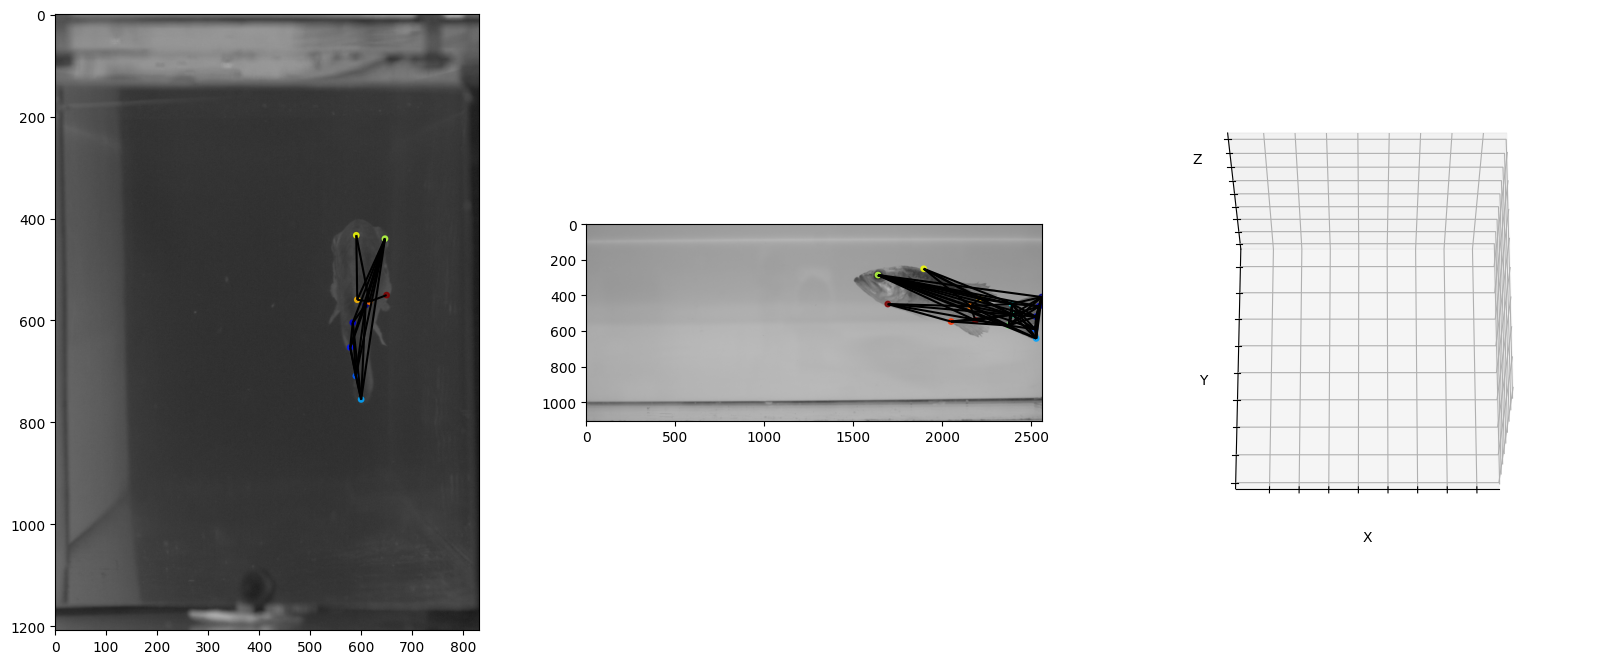

In [21]:
deeplabcut.create_labeled_video_3d(config_path_3d, [r'D:\UpAndDown\UpAndDown-Ming-2023-03-27-3d\videos'],
                 videotype='.mp4',
                 start=100, end=200)